# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint 
from importlib import reload
import logging
logging.basicConfig(level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import xarray as xr
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator


from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal

%matplotlib inline

root= pathlib.Path("/data")

A second order wrapper for `dt.canoncorr` to make it link with `PyalData`.

In [2]:
def CCA_pyal(df1:pd.DataFrame, field1: str, df2:pd.DataFrame =None, field2:str =None) -> np.array:
    if df2 is None:
        assert isinstance(field2,str), 'Enter a valid string in field2'
        df2 = df1

    d0 = np.concatenate(df1[field1].values, axis=0)
    d1 = np.concatenate(df2[field2].values, axis=0)

    # same number of timepoints in both matrices
    n_samples = min ([d0.shape[0], d1.shape[0]])
    d0 = d0[:n_samples,:]
    d1 = d1[:n_samples,:]

    CC = dt.canoncorr(d0, d1)

    return CC

### generate animal list

In [3]:
animalList = ['Chewie', 'Mihili']

animalFiles={}
for animal in animalList:
    animalFiles[animal] = utility.find_file(root / animal,'mat')

# just keeping the CS sessions
goodFiles = [file for animal in animalFiles for file in animalFiles[animal] if 'CS' in file]
pprint(goodFiles)

# keeping 1 session per animal
fileList = ['/data/Chewie/Chewie_CO_CS_2016-10-14.mat', '/data/Mihili/Mihili_CO_VR_2014-03-03.mat']


df_data=[]
for fname in fileList:
    df = pyal.mat2dataframe(fname, shift_idx_fields=True)
    df_data.append(df)


['/data/Chewie/Chewie_CO_CS_2016-10-14.mat',
 '/data/Chewie/Chewie_CO_CS_2016-10-21.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-12.mat',
 '/data/Mihili/Mihili_CO_CS_2014-09-29.mat',
 '/data/Mihili/Mihili_CO_CS_2015-05-11.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-26.mat',
 '/data/Mihili/Mihili_CO_CS_2014-06-27.mat',
 '/data/Mihili/Mihili_CO_CS_2014-12-03.mat']


average over every target, with fewer PCs

In [4]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25*np.pi))) - 1

def prep_pyalData_all_targets (df, n_components=10):
    df["target_id"] = df.apply(get_target_id, axis=1)  # add a field `target_id` with int values

    df_= pyal.add_firing_rates(df, 'smooth')
    df_= pyal.select_trials(df_, df_.result== 'R')
    df_= pyal.select_trials(df_, df_.epoch=='BL')
    
    df_ = pyal.remove_low_firing_neurons(df_, "M1_spikes", 1)
    df_ = pyal.remove_low_firing_neurons(df_, "PMd_spikes", 1)
    
    df_ = pyal.restrict_to_interval(df_, start_point_name='idx_movement_on', rel_start=0, rel_end=30)
    
    M1_rates = np.concatenate(df_.M1_rates.values, axis=0)
    pca_model = PCA(n_components=n_components, svd_solver='full');
    pca_model.fit(M1_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'M1_rates', 'M1_pca');

    PMd_rates = np.concatenate(df_.PMd_rates.values, axis=0)
    pca_model = PCA(n_components=n_components, svd_solver='full');
    pca_model.fit(PMd_rates);
    df_ = pyal.apply_dim_reduce_model(df_, pca_model, 'PMd_rates', 'PMd_pca');

    
    return df_

/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/msafaie/REPOS/MyPyalData/pyaldata/tools.py:940: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils

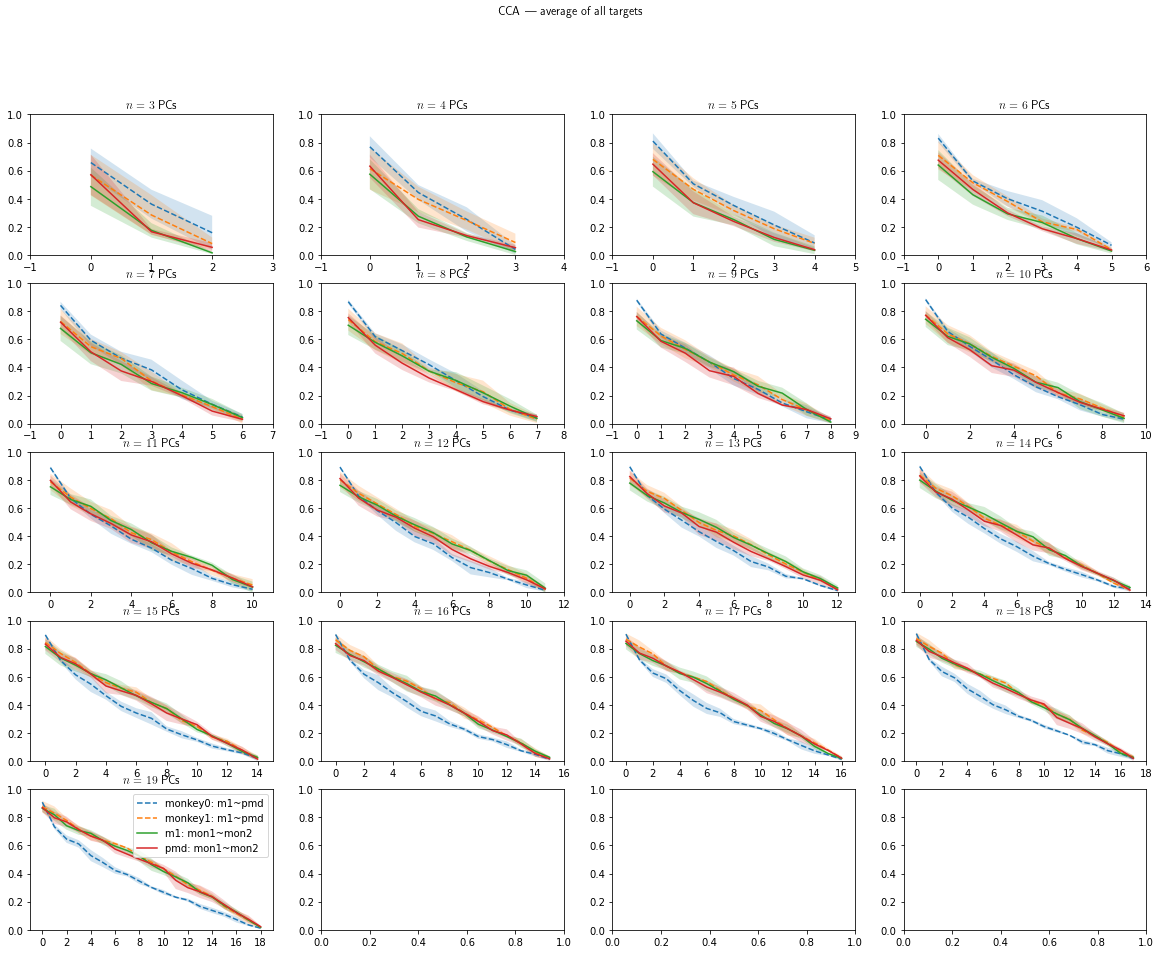

In [5]:
fig,axes = plt.subplots(5,4, figsize=(20,15))
warnings.filterwarnings("ignore")

for n_,ax in zip(range(3,20), axes.flatten()):
    df_data__ = [prep_pyalData_all_targets(df, n_) for  df in df_data]
     
    # The main CCs
    CC=[]
    for target in range(8):
        dfs = [pyal.select_trials(df_,df_.target_id==target) for df_ in df_data__]

        # monkey0: m1~pmd
        CC.append(CCA_pyal(dfs[0],'M1_pca', dfs[0],'PMd_pca'))
        # monkey1: m1~pmd
        CC.append(CCA_pyal(dfs[1],'M1_pca', dfs[1],'PMd_pca'))
        # m1: mon1~mon2
        CC.append(CCA_pyal(dfs[0],'M1_pca', dfs[1],'M1_pca'))
        # pmd: mon1~mon2
        CC.append(CCA_pyal(dfs[0],'PMd_pca', dfs[1],'PMd_pca'))

    CC= np.array(CC)

    # inter-target CCs
#     target_CC_M1=[]
#     target_CC_PMd=[]
#     for target0 in range(8):
#         dfs0 = [pyal.select_trials(df_,df_.target_id==target0) for df_ in df_data__]
#         for target1 in range(target0,8):
#             dfs1 = [pyal.select_trials(df_,df_.target_id==target1) for df_ in df_data__]

#             target_CC_M1.append(CCA_pyal(dfs0[0],'M1_pca', dfs1[0],'M1_pca'))
#             target_CC_M1.append(CCA_pyal(dfs0[1],'M1_pca', dfs1[1],'M1_pca'))

#             target_CC_PMd.append(CCA_pyal(dfs0[0],'PMd_pca', dfs1[0],'PMd_pca'))
#             target_CC_PMd.append(CCA_pyal(dfs0[1],'PMd_pca', dfs1[1],'PMd_pca'))


#     target_CC_M1= np.array(target_CC_M1)
#     target_CC_PMd= np.array(target_CC_PMd)


    utility.shaded_errorbar(ax,CC[0::8,:].T,ls='--',label='monkey0: m1~pmd')
    utility.shaded_errorbar(ax,CC[1::8,:].T,ls='--',label='monkey1: m1~pmd')
    utility.shaded_errorbar(ax,CC[2::8,:].T,label='m1: mon1~mon2')
    utility.shaded_errorbar(ax,CC[3::8,:].T,label='pmd: mon1~mon2')


#     ax.set_xlabel('components')
#     ax.set_ylabel('canonical correlation')
    ax.set_ylim([0,1])
    ax.set_xlim([-1,n_])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'$n={n_}$ PCs', usetex=True);

ax.legend()
fig.suptitle('CCA --- average of all targets', usetex=True);

I removed the inter-target traces, because the variability is too high and it covers everything!